In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.applications.resnet50 import ResNet50
import tensorflow as tf
import struct
from struct import unpack
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import json
import cairocffi as cairo
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import model_from_json
%matplotlib inline

In [3]:
def vector_to_raster(vector_images, side=28, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    """
    padding and line_diameter are relative to the original 256x256 image.
    """
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        
        bbox = np.hstack(vector_image).max(axis=1)
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]
    
        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)
    
    return raster_images

def unpack_drawing(file_handle, label):
    key_id, = unpack('Q', file_handle.read(8))
    countrycode, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = unpack(fmt, file_handle.read(n_points))
        y = unpack(fmt, file_handle.read(n_points))
        image.append((x, y))
    return (image, label)


def unpack_drawings(filename, label):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f, label)
            except struct.error as e:
                break

def unpack_draw(filename, label):
    list_drawing = []
    for drawing in unpack_drawings('data/' + filename + '.bin', label):
        # do something with the drawing
        list_drawing.append(drawing)
    
    return list_drawing

In [4]:
n_classes = 3
classes = ['axe', 'basketball', 'baseball bat']
data_list = unpack_draw('axe', 0)
data_list.extend(unpack_draw('basketball', 1))
data_list.extend(unpack_draw('baseball bat', 2))

In [5]:
data_list = shuffle(data_list)

In [6]:
data_image = np.array(vector_to_raster(list(map(lambda x: x[0], data_list))))

In [7]:
data_image = np.array(list(map(lambda x: np.reshape(np.array(x/255), (28,28,1)), data_image)))

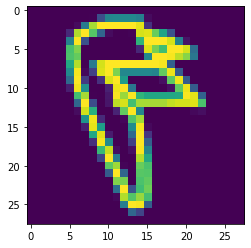

In [8]:
plt.imshow(np.reshape(data_image[0], (28,28)))

In [9]:
data_labels = np.array(list(map(lambda x: tf.keras.utils.to_categorical(x[1], num_classes=n_classes), data_list)))

In [10]:
draw_train, draw_test, label_train, label_test = \
train_test_split(data_image, data_labels, test_size=0.3)

In [12]:
label_train.shape

(267206, 3)

In [11]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(28, 28, 1), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(2, 2), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Conv2D(filters=32, kernel_size=(2, 2), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Conv2D(filters=32, kernel_size=(2, 2), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [12]:
def save_model(model, name='model1'):
    # serialize model to JSON
    model_json = model.to_json()
    with open("{0}.json".format(name), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("{0}.h5".format(name))
    print("Saved model to disk")

def load_model(name='model1'):
    json_file = open("{0}.json".format(name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("{0}.h5".format(name))
    print("Loaded model from disk")
    return loaded_model

def optimizer():
    return SGD(lr=1e-2)

In [13]:
batch_size = 800

In [17]:
model_name = 'model1'
try:
    model = load_model(model_name)
except:
    model = create_model()
model.compile(optimizer=optimizer(),
          loss='categorical_crossentropy',
          metrics=['accuracy']
          )
model.fit(draw_train, label_train, batch_size=batch_size, epochs=5, validation_data=(draw_test,label_test),verbose=1)
model.summary()
save_model(model, model_name)

Loaded model from disk
Train on 267206 samples, validate on 114518 samples
Epoch 1/5
267206/267206 [==============================] - 40s 148us/sample - loss: 0.3101 - accuracy: 0.9003 - val_loss: 0.2562 - val_accuracy: 0.9144
Epoch 2/5
267206/267206 [==============================] - 39s 147us/sample - loss: 0.2718 - accuracy: 0.9121 - val_loss: 0.2312 - val_accuracy: 0.9248
Epoch 3/5
267206/267206 [==============================] - 39s 147us/sample - loss: 0.2520 - accuracy: 0.9171 - val_loss: 0.2229 - val_accuracy: 0.9236
Epoch 4/5
267206/267206 [==============================] - 39s 148us/sample - loss: 0.2372 - accuracy: 0.9214 - val_loss: 0.2269 - val_accuracy: 0.9253
Epoch 5/5
267206/267206 [==============================] - 40s 148us/sample - loss: 0.2245 - accuracy: 0.9256 - val_loss: 0.2724 - val_accuracy: 0.9112
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True